## Boosted regression trees
Trying boosted regression trees in the gbm package, including lag and lead for all variables except depth.

[This is me](https://www.linkedin.com/in/%C3%B8ystein-s%C3%B8rensen-4a877831/)

## Data load

In [106]:
trainingData <- read.csv("../training_data.csv")
testData <- read.csv("../validation_data_nofacies.csv")

# Convert the class labels to factors
trainingData$Facies <- as.factor(trainingData$Facies)

# Add a Facies column to test data
testData <- cbind(Facies = as.factor(-1), testData)

## Some feature engineering
Adding lead and lag for every row. In the top and bottom, I replace NA with the current value.

In [107]:
# Reorganizing the columns, putting the columns to have lag/lead at the end
order <- c("Facies", "Well.Name", "Depth", "RELPOS", "Formation", "GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M")

trainingData <- trainingData[, order]
testData <- testData[, order]

Printing out the data frame to confirm that the transformation was correct.

In [94]:
head(trainingData)
head(testData)

Facies,Well.Name,Depth,RELPOS,Formation,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M
3,SHRIMPLIN,2793.0,1.000,A1 SH,77.45,0.664,9.9,11.915,4.6,1
3,SHRIMPLIN,2793.5,0.979,A1 SH,78.26,0.661,14.2,12.565,4.1,1
3,SHRIMPLIN,2794.0,0.957,A1 SH,79.05,0.658,14.8,13.050,3.6,1
3,SHRIMPLIN,2794.5,0.936,A1 SH,86.10,0.655,13.9,13.115,3.5,1
3,SHRIMPLIN,2795.0,0.915,A1 SH,74.58,0.647,13.5,13.300,3.4,1
3,SHRIMPLIN,2795.5,0.894,A1 SH,73.97,0.636,14.0,13.385,3.6,1


Facies,Well.Name,Depth,RELPOS,Formation,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M
-1,STUART,2808.0,1.000,A1 SH,66.276,0.630,3.3,10.65,3.591,1
-1,STUART,2808.5,0.978,A1 SH,77.252,0.585,6.5,11.95,3.341,1
-1,STUART,2809.0,0.956,A1 SH,82.899,0.566,9.4,13.60,3.064,1
-1,STUART,2809.5,0.933,A1 SH,80.671,0.593,9.5,13.25,2.977,1
-1,STUART,2810.0,0.911,A1 SH,75.971,0.638,8.7,12.35,3.020,1
-1,STUART,2810.5,0.889,A1 SH,73.955,0.667,6.9,12.25,3.086,1


In [108]:
library(dplyr)

featureEng <- function(x) {
    x <- x %>%    
        group_by(Well.Name) %>%
        mutate(
            prev.Formation = lag(Formation), prev2.Formation = lag(Formation, 2),
            next.Formation = lead(Formation), next2.Formation = lead(Formation, 2),
            prev.GR = lag(GR), prev2.GR = lag(GR, 2), 
            next.GR = lead(GR), next2.GR = lead(GR, 2),
            prev.ILD_log10 = lag(ILD_log10), prev2.ILD_log10 = lag(ILD_log10, 2),
            next.ILD_log10 = lead(ILD_log10), next2.ILD_log10 = lead(ILD_log10, 2),
            prev.DeltaPHI = lag(DeltaPHI), prev2.DeltaPHI = lag(DeltaPHI, 2), 
            next.DeltaPHI = lead(DeltaPHI), next2.DeltaPHI = lead(DeltaPHI, 2),
            prev.PHIND = lag(PHIND), prev2.PHIND = lag(PHIND, 2), 
            next.PHIND = lead(PHIND), next2.PHIND = lead(PHIND, 2),
            prev.PE = lag(PE), prev2.PE = lag(PE, 2), 
            next.PE = lead(PE), next2.PE = lead(PE, 2),
            prev.NM_M = lag(NM_M), prev2.NM_M = lag(NM_M, 2), 
            next.NM_M = lead(NM_M), next2.NM_M = lead(NM_M, 2)
        )        

    vec <- 5:11 # The columns which have lag/lead
    vec2 <- ((vec + 7) + seq(from = 0, length.out = 7, by = 3))
    for(i in seq_along(vec)) {         
        rows <- is.na(x[, vec2[i]])
        x[rows, vec2[i]] <- x[rows, vec[i]]        
        rows <- is.na(x[, vec2[i] + 1])
        x[rows, vec2[i] + 1] <- x[rows, vec[i]]        
        rows <- is.na(x[, vec2[i] + 2])
        x[rows, vec2[i] + 2] <- x[rows, vec[i]]        
        rows <- is.na(x[, vec2[i] + 3])
        x[rows, vec2[i] + 3] <- x[rows, vec[i]]
        }
    return(x)
}


In [109]:
trainingData <- featureEng(trainingData)
testData <- featureEng(testData)

In [110]:
head(trainingData)

Facies,Well.Name,Depth,RELPOS,Formation,GR,ILD_log10,DeltaPHI,PHIND,PE,...,next.PHIND,next2.PHIND,prev.PE,prev2.PE,next.PE,next2.PE,prev.NM_M,prev2.NM_M,next.NM_M,next2.NM_M
3,SHRIMPLIN,2793.0,1.000,A1 SH,77.45,0.664,9.9,11.915,4.6,...,12.565,13.050,4.6,4.6,4.1,3.6,1,1,1,1
3,SHRIMPLIN,2793.5,0.979,A1 SH,78.26,0.661,14.2,12.565,4.1,...,13.050,13.115,4.6,4.1,3.6,3.5,1,1,1,1
3,SHRIMPLIN,2794.0,0.957,A1 SH,79.05,0.658,14.8,13.050,3.6,...,13.115,13.300,4.1,4.6,3.5,3.4,1,1,1,1
3,SHRIMPLIN,2794.5,0.936,A1 SH,86.10,0.655,13.9,13.115,3.5,...,13.300,13.385,3.6,4.1,3.4,3.6,1,1,1,1
3,SHRIMPLIN,2795.0,0.915,A1 SH,74.58,0.647,13.5,13.300,3.4,...,13.385,13.930,3.5,3.6,3.6,3.7,1,1,1,1
3,SHRIMPLIN,2795.5,0.894,A1 SH,73.97,0.636,14.0,13.385,3.6,...,13.930,13.920,3.4,3.5,3.7,3.5,1,1,1,1


## Multinomial boosted tree model

Performing my own cross-validation procedure, in order to use the F1 measure as metric.

In [111]:
form <- as.formula(paste("Facies ~ ", paste(colnames(trainingData[, -(1:2)]), collapse = "+"), sep = " "))
form

Facies ~ Depth + RELPOS + Formation + GR + ILD_log10 + DeltaPHI + 
    PHIND + PE + NM_M + prev.Formation + prev2.Formation + next.Formation + 
    next2.Formation + prev.GR + prev2.GR + next.GR + next2.GR + 
    prev.ILD_log10 + prev2.ILD_log10 + next.ILD_log10 + next2.ILD_log10 + 
    prev.DeltaPHI + prev2.DeltaPHI + next.DeltaPHI + next2.DeltaPHI + 
    prev.PHIND + prev2.PHIND + next.PHIND + next2.PHIND + prev.PE + 
    prev2.PE + next.PE + next2.PE + prev.NM_M + prev2.NM_M + 
    next.NM_M + next2.NM_M

In [112]:
library(PerfMeas) # Contains the F1 metric
library(gbm) # Using the gbm package
library(caret) # For cross-validation

nFolds <- 10
crossVal <- createFolds(trainingData$Facies, k = nFolds) # Index of training data

In [113]:
maxTrees <- 25000
treeSeq <- floor(seq(1, maxTrees, length.out = 100))

foldSeq <- 1:nFolds
# Training the model using 10-fold cross validation

trainingAlgorithm <- function(i) {
    library(gbm)
    library(PerfMeas)
    fscore <- treeSeq * 0
    fit <- gbm(form,
       distribution = "multinomial",
       n.trees = maxTrees,
       shrinkage = 0.0005,
       interaction.depth = 10,           
       data = trainingData[crossVal[[i]], ], 
       keep.data = FALSE           
      )
    pred <- predict.gbm(fit, newdata = trainingData[-crossVal[[i]], ], n.trees = treeSeq)
    yhat <- t(apply(pred, 1, function(x) apply(x, 2, which.max)))
    ytrue <- trainingData$Facies[-crossVal[[i]]]
    classes <- sort(unique(ytrue))
  
    Target <- t(t(as.numeric(ytrue) %*% t(rep(1,length(classes)))) == classes) * 1.0
        
    for(j in seq_along(treeSeq)) {
        Pred <- t(t(as.numeric(yhat[, j]) %*% t(rep(1,length(classes)))) == classes) * 1.0
        fscore[j] <- mean(sapply(classes, function(x) F.measure.single(labels = Target[, x], pred = Pred[, x])['F']))
    }  
    return(fscore)
}



In [114]:
cl <- makeCluster(5)
clusterExport(cl, c("treeSeq", "crossVal", "trainingData", "form", "maxTrees"))
fscores <- parSapply(cl, foldSeq, trainingAlgorithm)
stopCluster(cl)

Inspecting the cross-validation results, choosing the number of trees at the optimum.

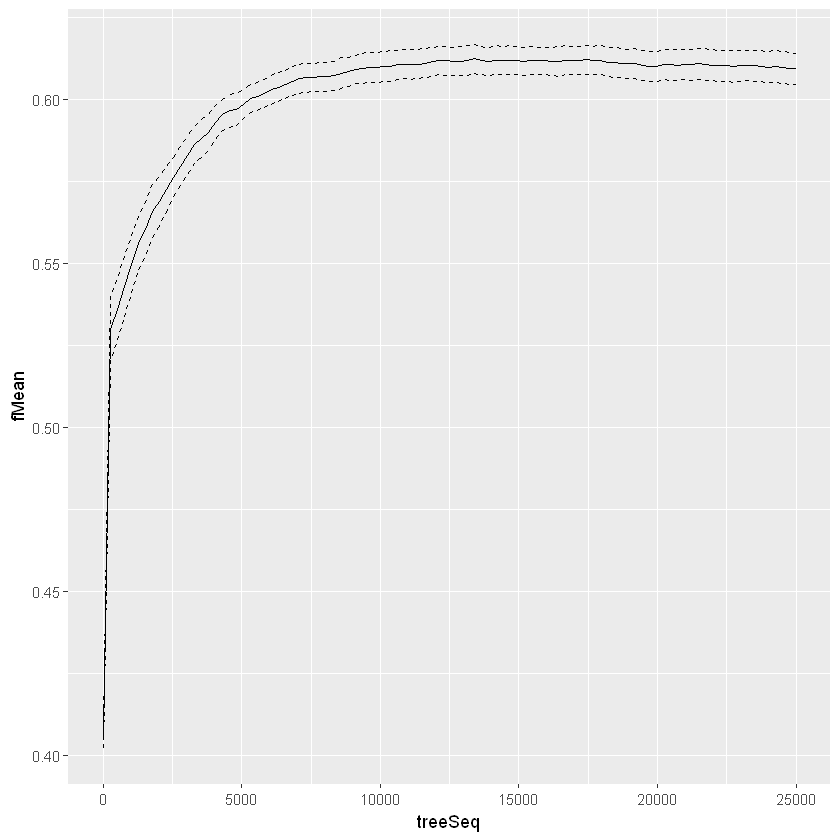

In [115]:
df <- data.frame(treeSeq = treeSeq,
                fMean = rowMeans(fscores),
                fSE = apply(fscores, 1, sd) / sqrt(nFolds))

ggplot(df, aes(x = treeSeq, y = fMean)) +
    geom_line() +
    geom_line(aes(y = fMean - fSE), linetype = 2) +
    geom_line(aes(y = fMean + fSE), linetype = 2)



In [120]:
finalTrees <- treeSeq[which.max(df$fMean)]
fit <- gbm(form,
                distribution = "multinomial",
                n.trees = finalTrees,
                shrinkage = 0.0005,
                interaction.depth = 10,           
                data = trainingData, 
                keep.data = FALSE      
               )

,var,rel.inf
Formation,Formation,23.941018256
Depth,Depth,10.729285560
RELPOS,RELPOS,5.343437525
next.GR,next.GR,5.155298632
GR,GR,4.754038853
next2.ILD_log10,next2.ILD_log10,3.957988974
PHIND,PHIND,3.788894580
next2.Formation,next2.Formation,3.696785559
prev2.Formation,prev2.Formation,3.497037054
next2.PE,next2.PE,2.509695201


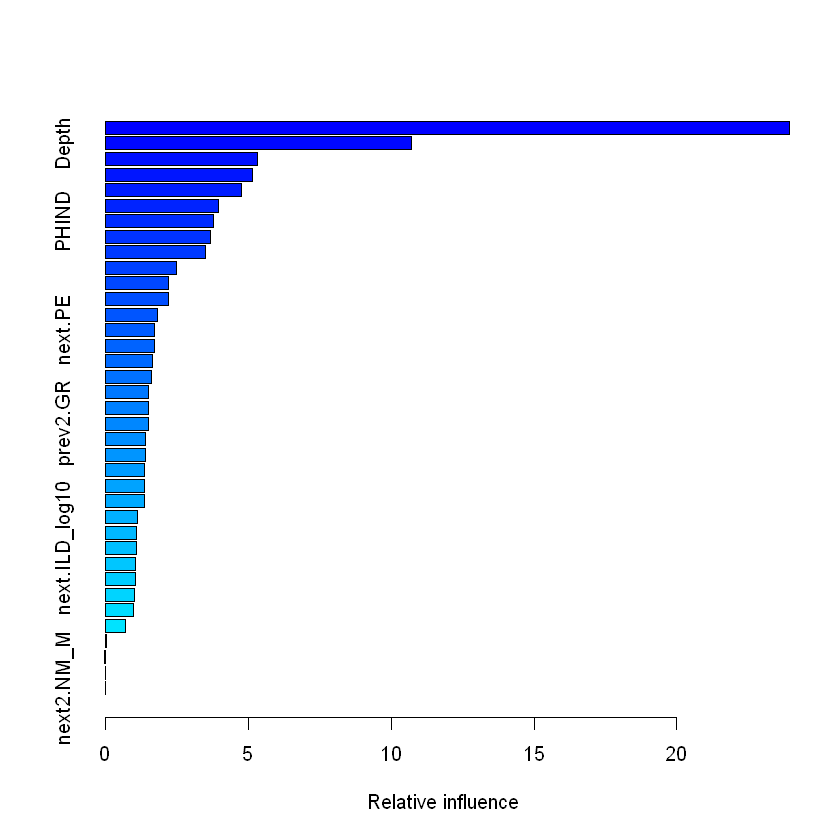

In [121]:
summary(fit)

Reassuring to see that the out-of-bag error is not yet at its minimum. Hope this means that I do not overfit...

Using OOB method...


Warning message in gbm.perf(fit):
"OOB generally underestimates the optimal number of iterations although predictive performance is reasonably competitive. Using cv.folds>0 when calling gbm usually results in improved predictive performance."

[1] 11896

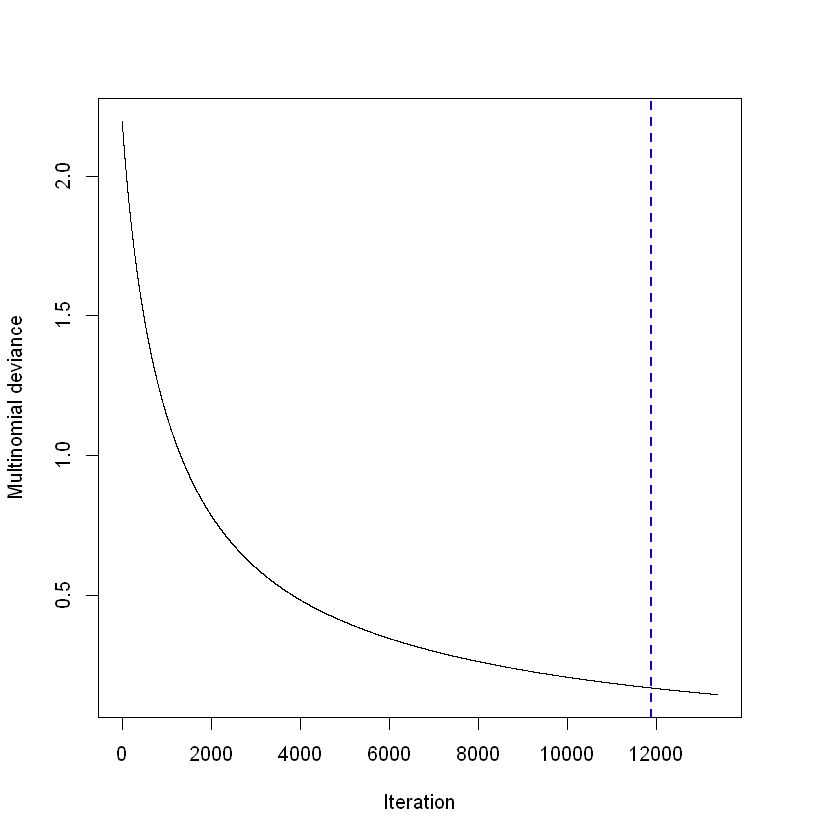

In [122]:
gbm.perf(fit)

## Prediction

In [125]:
# Compute the link function
estimatedLink <- predict(fit, newdata = testData, type = "link", n.trees = finalTrees)[,,1]
# Use the classification with highest probability
testData$Facies <- apply(estimatedLink, 1, which.max)

Warning message in predict.gbm(fit, newdata = testData, type = "link", n.trees = finalTrees):
"Number of trees not specified or exceeded number fit so far. Using 13384."

In [126]:
head(testData)

Facies,Well.Name,Depth,RELPOS,Formation,GR,ILD_log10,DeltaPHI,PHIND,PE,...,next.PHIND,next2.PHIND,prev.PE,prev2.PE,next.PE,next2.PE,prev.NM_M,prev2.NM_M,next.NM_M,next2.NM_M
2,STUART,2808.0,1.000,A1 SH,66.276,0.630,3.3,10.65,3.591,...,11.95,13.60,3.591,3.591,3.341,3.064,1,1,1,1
3,STUART,2808.5,0.978,A1 SH,77.252,0.585,6.5,11.95,3.341,...,13.60,13.25,3.591,3.341,3.064,2.977,1,1,1,1
3,STUART,2809.0,0.956,A1 SH,82.899,0.566,9.4,13.60,3.064,...,13.25,12.35,3.341,3.591,2.977,3.020,1,1,1,1
3,STUART,2809.5,0.933,A1 SH,80.671,0.593,9.5,13.25,2.977,...,12.35,12.25,3.064,3.341,3.020,3.086,1,1,1,1
3,STUART,2810.0,0.911,A1 SH,75.971,0.638,8.7,12.35,3.020,...,12.25,12.45,2.977,3.064,3.086,3.092,1,1,1,1
3,STUART,2810.5,0.889,A1 SH,73.955,0.667,6.9,12.25,3.086,...,12.45,12.65,3.020,2.977,3.092,3.123,1,1,1,1


In [127]:
# Write to csv
write.csv(testData, file = "./prediction.csv", row.names = FALSE)